In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import table
from plotly import graph_objs as go
import seaborn as sns 
import nltk 
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS

In [3]:
df = pd.read_csv('/Users/rashidbaset/Code/twitter-sentiment-prediction/_data/raw-data/Tweets.csv')
data = df[['tweet_id','name', 'airline_sentiment', 'text', 'tweet_created', 'user_timezone', 'tweet_location']]
stopwords_man = set(stopwords.words('english'))
train_label = pd.DataFrame(data.iloc[:,2].values)
train_data = pd.DataFrame(data.iloc[:,-4].values)
stemmer_ = SnowballStemmer('english')


In [ ]:
### Dataset Dictionary

| Feature                      | Definition                                            | Unique keys                                                                       | Drop? | If yes, reason |
|------------------------------|-------------------------------------------------------|-----------------------------------------------------------------------------------|-------|----------------|
| tweet_id                     |                                                       |                                                                                   |       |                |
| airline_sentiment            | Sentiment of tweet                                    | Positive, neutral, negative                                                       | No    |                |
| airline_sentiment_confidence | Confidence of sentiment classification of contributor | 0.34 - 1.00                                                                       | No    |                |
| negativereason               |                                                       | Customer service issues, late flight, can't tell, cancelled flight,  lost luggage | No    |                |
| negativereason_confidence    |                                                       | 0.00 - 1.00                                                                       |       |                |
| airline                      |                                                       | United, US Airways, American, Southewest, Delta                                   |       |                |
| airline_sentiment_gold       |                                                       | Negative, positive, neutral                                                       |       |                |
| retweet_count                |                                                       | Continuous, mean=.083                                                             |       |                |
| text                         |                                                       | Mean length = 104, Max, min length = 197, 12                                      |       |                |
| tweet_coord                  |                                                       | Distinct = 832, Non-empty=1,019, Empty = 13,621                                   |       |                |
| tweet_created                |                                                       |                                                                                   |       |                |
| tweet_location               |                                                       | Empty = 4,733 (32%)                                                               |       |                |
| user_timezone                |                                                       | Empty = 4,820 (32.9%)                                                             |       |                |

In [ ]:
### Data Types

| Quantitative:  | Cotinuous                  | Discrete       |
|----------------|----------------------------|----------------|
|                | retweet_count, confidences |                |
| Categorical    | Ordinal                    | Nominal        |
|                | airline_sentiment          | negativereason |

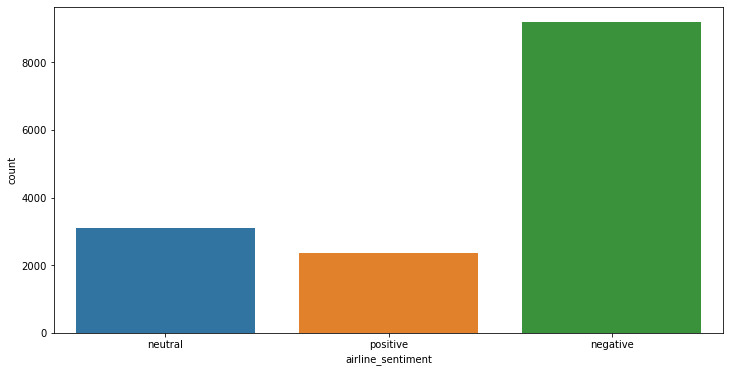

In [8]:
plt.figure(figsize=(12,6))
sns.countplot(x='airline_sentiment',data= df)

In [16]:
data[data.airline_sentiment.str.contains('negative', case=False)].head()

,tweet_id,name,airline_sentiment,text,tweet_created,user_timezone,tweet_location
3,570301031407624196,jnardino,negative,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,Pacific Time (US & Canada),NaN
4,570300817074462722,jnardino,negative,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,Pacific Time (US & Canada),NaN
5,570300767074181121,jnardino,negative,@VirginAmerica seriously would pay $30 a fligh...,2015-02-24 11:14:33 -0800,Pacific Time (US & Canada),NaN
15,570282469121007616,smartwatermelon,negative,@VirginAmerica SFO-PDX schedule is still MIA.,2015-02-24 10:01:50 -0800,Pacific Time (US & Canada),"palo alto, ca"
17,570276917301137409,heatherovieda,negative,@VirginAmerica I flew from NYC to SFO last we...,2015-02-24 09:39:46 -0800,Eastern Time (US & Canada),this place called NYC


In [17]:
data[data.airline_sentiment.str.contains('positive', case=False)].head()

,tweet_id,name,airline_sentiment,text,tweet_created,user_timezone,tweet_location
1,570301130888122368,jnardino,positive,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,Pacific Time (US & Canada),NaN
6,570300616901320704,cjmcginnis,positive,"@VirginAmerica yes, nearly every time I fly VX...",2015-02-24 11:13:57 -0800,Pacific Time (US & Canada),San Francisco CA
8,570299953286942721,dhepburn,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D",2015-02-24 11:11:19 -0800,Pacific Time (US & Canada),San Diego
9,570295459631263746,YupitsTate,positive,"@VirginAmerica it was amazing, and arrived an ...",2015-02-24 10:53:27 -0800,Eastern Time (US & Canada),Los Angeles
11,570289724453216256,HyperCamiLax,positive,@VirginAmerica I &lt;3 pretty graphics. so muc...,2015-02-24 10:30:40 -0800,America/New_York,NYC


In [4]:
def tweet_clean(tweet):
    tweet=re.sub(r'@[A-Za-z0-9]+'," ",tweet) ##Removing the usernames
    tweet=re.sub(r'^[A-Za-z0-9.!?]+'," ",tweet) ##Removing digits and punctuations
    tweet=re.sub(r'https?://[A-Za-z0-9./]+'," ",tweet) ## removing links
    tweet=re.sub(r' +'," ",tweet)
    tweet = tweet.lower()
    tweet = re.sub(r"\'s", " ", tweet)
    tweet = re.sub(r"\'ve", " have ", tweet)
    tweet = re.sub(r"can't", "cannot ", tweet)
    tweet = re.sub(r"n't", " not ", tweet)
    tweet = re.sub(r"\'d", " would ", tweet)
    tweet = re.sub(r"\'ll", " will ", tweet)
    tweet = re.sub(r"\'scuse", " excuse ", tweet)
    tweet = tweet.strip(' ')
    tweet = tweet.strip('. .')
    tweet = tweet.replace('.',' ')
    tweet = tweet.replace('-',' ')
    tweet = tweet.replace("’", "'").replace("′", "'").replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")
    tweet = tweet.replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")
    tweet = tweet.replace("€", " euro ").replace("'ll", " will")
    tweet = tweet.replace("don't", "do not").replace("didn't", "did not").replace("im","i am").replace("it's", "it is")
    tweet = tweet.replace(",000,000", "m").replace("n't", " not").replace("what's", "what is")
    tweet = tweet.replace(",000", "k").replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")
    tweet = tweet.replace("he's", "he is").replace("she's", "she is").replace("'s", " own")
    tweet = re.sub('\s+', ' ', tweet)
    tweet=tweet.split()
    tweet=[stemmer_.stem(word) for word in tweet if word not in stopwords_man]
    tweet=' '.join(word for word in tweet)

    #all_stopwords = stopwords.words('english')
    return tweet.lower()



In [6]:
train_data

,0
0,@VirginAmerica What @dhepburn said.
1,@VirginAmerica plus you've added commercials t...
2,@VirginAmerica I didn't today... Must mean I n...
3,@VirginAmerica it's really aggressive to blast...
4,@VirginAmerica and it's a really big bad thing...
...,...
14635,@AmericanAir thank you we got on a different f...
14636,@AmericanAir leaving over 20 minutes Late Flig...
14637,@AmericanAir Please bring American Airlines to...
14638,"@AmericanAir you have my money, you change my ..."


In [5]:
tweets_clean=[tweet_clean(tweet) for tweet in train_data]

TypeError: expected string or bytes-like object